In [33]:
# Data libs
import pandas as pd
import numpy as np

# ML libs
import sklearn
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, log_loss, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.calibration import CalibratedClassifierCV

import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Utils
import pickle
import warnings
import datetime

# Graph libs
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

# Settings
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)
warnings.filterwarnings('ignore')

# Global vars
random_state = 33

In [3]:
# Read data
df0 = pd.read_csv('dataset.csv', sep =';')

# Select rows where default != NaN
df = df0[df0['default'].isna() == False ]

In [4]:
X = df.drop(['uuid','default'],axis=1)
y = df['default']

In [5]:
# Split data into Train, Test, and Validation datasets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state,stratify=y_train) # 0.25*0.8 = 0.2

In [6]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median'))
])


cat_cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999))
])


cat_num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant',fill_value=999))
])

In [7]:
feature_pipeline = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,
     
     [
       'account_amount_added_12_24m',
       'account_days_in_dc_12_24m', 'account_days_in_rem_12_24m',
       'account_days_in_term_12_24m', 'account_incoming_debt_vs_paid_0_24m',
       'age', 'avg_payment_span_0_12m', 'avg_payment_span_0_3m',
       'max_paid_inv_0_12m', 'max_paid_inv_0_24m',
       'num_active_div_by_paid_inv_0_12m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 'num_arch_ok_0_12m',
       'num_arch_ok_12_24m', 'num_arch_rem_0_12m',
       'num_arch_written_off_0_12m', 'num_arch_written_off_12_24m',
       'num_unpaid_bills','recovery_debt',
       'sum_capital_paid_account_0_12m', 'sum_capital_paid_account_12_24m',
       'sum_paid_inv_0_12m', 'time_hours'
        ]),
    
    
    ('cat_cat_pipeline',cat_cat_pipeline,
     
     [
        'merchant_category', 'merchant_group',
        'name_in_email', 'has_paid',
        ]),
    
    
    ('cat_num_pipeline',cat_num_pipeline,
     
     [
       'account_status', 'account_worst_status_0_3m',
       'account_worst_status_12_24m', 'account_worst_status_3_6m',
       'account_worst_status_6_12m',  
         'status_last_archived_0_24m',
       'status_2nd_last_archived_0_24m', 'status_3rd_last_archived_0_24m',
       'status_max_archived_0_6_months', 'status_max_archived_0_12_months',
       'status_max_archived_0_24_months', 'worst_status_active_inv'
        ])
    
    ],
    remainder='drop',
    n_jobs=-1)

In [ ]:
#'scale_pos_weight':Real(1e-5,1,prior='log-uniform')

In [13]:
xgb_cl = xgb.XGBClassifier(objective='binary:logistic',random_state=random_state)
                          

parameters = {'n_estimators':Integer(20,200,prior='uniform'),
              'max_depth':Integer(4,16,prior='uniform'),
              'learning_rate':Real(1e-4,3e-1,prior='log-uniform'),
              'reg_alpha':Real(1e-5,100,prior='log-uniform'),
              'reg_lambda':Real(1e-5,100,prior='log-uniform'),
              'max_delta_step':Real(1,10,prior='uniform'),
              'scale_pos_weight':Real(60,80,prior='log-uniform')
              }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

xgb_cv = BayesSearchCV(xgb_cl, parameters, cv=cv, n_jobs=-1, scoring='neg_log_loss', verbose=4, n_iter=20)

In [14]:
xgb_pipeline = Pipeline(steps=[
    ('feature_pipeline', feature_pipeline),
    ('model', xgb_cv)
])

In [15]:
xgb_pipeline.fit(X_train, y_train,
                 model__early_stopping_rounds=10,
                 model__eval_metric = 'auc',
                 model__eval_set=[[feature_pipeline.fit_transform(X_val),y_val]])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[0]	validation_0-auc:0.85704
[0]	validation_0-auc:0.85049
[1]	validation_0-auc:0.85700


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[1]	validation_0-auc:0.85132
[2]	validation_0-auc:0.85899
[2]	validation_0-auc:0.85105
[0]	validation_0-auc:0.85876
[0]	validation_0-auc:0.85403
[0]	validation_0-auc:0.85350
[3]	validation_0-auc:0.85916
[3]	validation_0-auc:0.84875
[1]	validation_0-auc:0.85984
[1]	validation_0-auc:0.85045
[1]	validation_0-auc:0.85395
[4]	validation_0-auc:0.85323
[4]	validation_0-auc:0.84511
[2]	validation_0-auc:0.85075
[2]	validation_0-auc:0.86003
[2]	validation_0-auc:0.85628
[5]	validation_0-auc:0.85509
[5]	validation_0-auc:0.84429
[3]	validation_0-auc:0.84563
[3]	validation_0-auc:0.85844
[3]	validation_0-auc:0.85687
[6]	validation_0-auc:0.85377
[6]	validation_0-auc:0.84436
[4]	validation_0-auc:0.84624
[4]	validation_0-auc:0.85589
[4]	validation_0-auc:0.85813
[7]	validation_0-auc:0.84426
[7]	validation_0-auc:0.85603
[5]	validation_0-auc:0.84683
[5]	validation_0-auc:0.85727
[5]	validation_0-auc:0.85643
[8]	validation_0-auc:0.84248
[8]	validation_0-auc:0.85381
[6]	validation_0-auc:0.85814
[6]	validation

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 3/5] END learning_rate=0.03847942520003286, max_delta_step=6.7423720331164, max_depth=12, n_estimators=69, reg_alpha=0.18138768398286542, reg_lambda=0.5529371577280596, scale_pos_weight=70.81444950071827;, score=-0.539 total time=   2.8s
[0]	validation_0-auc:0.76674
[CV 2/5] END learning_rate=0.03847942520003286, max_delta_step=6.7423720331164, max_depth=12, n_estimators=69, reg_alpha=0.18138768398286542, reg_lambda=0.5529371577280596, scale_pos_weight=70.81444950071827;, score=-0.666 total time=   2.1s
[0]	validation_0-auc:0.84601
[0]	validation_0-auc:0.84017
[CV 4/5] END learning_rate=0.03847942520003286, max_delta_step=6.7423720331164, max_depth=12, n_estimators=69, reg_alpha=0.18138768398286542, reg_lambda=0.5529371577280596, scale_pos_weight=70.81444950071827;, score=-0.595 total time=   2.6s
[0]	validation_0-auc:0.77365
[0]	validation_0-auc:0.82366
[1]	validation_0-auc:0.77022
[1]	validation_0-auc:0.85453
[1]	validation_0-auc:0.85350
[1]	validation_0-auc:0.77378
[1]	validatio

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 5/5] END learning_rate=0.0007247941089496274, max_delta_step=8.992773260570692, max_depth=8, n_estimators=164, reg_alpha=0.012647636691713916, reg_lambda=4.188453077155816e-05, scale_pos_weight=61.334238809476375;, score=-0.682 total time=   3.8s
[0]	validation_0-auc:0.84354
[0]	validation_0-auc:0.84173
[CV 5/5] END learning_rate=0.03847942520003286, max_delta_step=6.7423720331164, max_depth=12, n_estimators=69, reg_alpha=0.18138768398286542, reg_lambda=0.5529371577280596, scale_pos_weight=70.81444950071827;, score=-0.640 total time=   2.3s
[0]	validation_0-auc:0.85743
[CV 1/5] END learning_rate=0.0007247941089496274, max_delta_step=8.992773260570692, max_depth=8, n_estimators=164, reg_alpha=0.012647636691713916, reg_lambda=4.188453077155816e-05, scale_pos_weight=61.334238809476375;, score=-0.690 total time=   2.1s
[0]	validation_0-auc:0.85699
[CV 3/5] END learning_rate=0.0007247941089496274, max_delta_step=8.992773260570692, max_depth=8, n_estimators=164, reg_alpha=0.0126476366917

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 1/5] END learning_rate=0.29696893688057197, max_delta_step=4.763876449517056, max_depth=10, n_estimators=133, reg_alpha=0.03422000932786761, reg_lambda=0.29157646594951836, scale_pos_weight=63.88441023565738;, score=-0.142 total time=   3.5s
[0]	validation_0-auc:0.85794
[CV 2/5] END learning_rate=0.29696893688057197, max_delta_step=4.763876449517056, max_depth=10, n_estimators=133, reg_alpha=0.03422000932786761, reg_lambda=0.29157646594951836, scale_pos_weight=63.88441023565738;, score=-0.072 total time=  13.6s
[0]	validation_0-auc:0.85066
[CV 2/5] END learning_rate=0.0007247941089496274, max_delta_step=8.992773260570692, max_depth=8, n_estimators=164, reg_alpha=0.012647636691713916, reg_lambda=4.188453077155816e-05, scale_pos_weight=61.334238809476375;, score=-0.691 total time=   2.0s
[0]	validation_0-auc:0.85439
[CV 1/5] END learning_rate=0.03847942520003286, max_delta_step=6.7423720331164, max_depth=12, n_estimators=69, reg_alpha=0.18138768398286542, reg_lambda=0.552937157728059

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 3/5] END learning_rate=0.005293252531696876, max_delta_step=6.5340723301018, max_depth=10, n_estimators=190, reg_alpha=1.5057906551369336, reg_lambda=0.5180368910831599, scale_pos_weight=68.30408173395553;, score=-0.596 total time=   5.6s
[0]	validation_0-auc:0.84566
[CV 2/5] END learning_rate=0.005293252531696876, max_delta_step=6.5340723301018, max_depth=10, n_estimators=190, reg_alpha=1.5057906551369336, reg_lambda=0.5180368910831599, scale_pos_weight=68.30408173395553;, score=-0.622 total time=   4.7s
[0]	validation_0-auc:0.84736
[CV 5/5] END learning_rate=0.005293252531696876, max_delta_step=6.5340723301018, max_depth=10, n_estimators=190, reg_alpha=1.5057906551369336, reg_lambda=0.5180368910831599, scale_pos_weight=68.30408173395553;, score=-0.626 total time=   4.4s
[0]	validation_0-auc:0.84552
[CV 4/5] END learning_rate=0.0007247941089496274, max_delta_step=8.992773260570692, max_depth=8, n_estimators=164, reg_alpha=0.012647636691713916, reg_lambda=4.188453077155816e-05, sca

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 1/5] END learning_rate=0.005293252531696876, max_delta_step=6.5340723301018, max_depth=10, n_estimators=190, reg_alpha=1.5057906551369336, reg_lambda=0.5180368910831599, scale_pos_weight=68.30408173395553;, score=-0.631 total time=   4.0s
[0]	validation_0-auc:0.85835
[CV 3/5] END learning_rate=0.004557429129574164, max_delta_step=3.73043289878341, max_depth=12, n_estimators=101, reg_alpha=0.0009805462180298384, reg_lambda=0.004702558002736251, scale_pos_weight=70.57833154466161;, score=-0.619 total time=   5.4s
[0]	validation_0-auc:0.77785
[CV 5/5] END learning_rate=0.29696893688057197, max_delta_step=4.763876449517056, max_depth=10, n_estimators=133, reg_alpha=0.03422000932786761, reg_lambda=0.29157646594951836, scale_pos_weight=63.88441023565738;, score=-0.521 total time=   1.8s
[0]	validation_0-auc:0.86378
[CV 4/5] END learning_rate=0.005293252531696876, max_delta_step=6.5340723301018, max_depth=10, n_estimators=190, reg_alpha=1.5057906551369336, reg_lambda=0.5180368910831599, s

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 5/5] END learning_rate=0.004557429129574164, max_delta_step=3.73043289878341, max_depth=12, n_estimators=101, reg_alpha=0.0009805462180298384, reg_lambda=0.004702558002736251, scale_pos_weight=70.57833154466161;, score=-0.661 total time=   3.4s
[0]	validation_0-auc:0.85574
[CV 1/5] END learning_rate=0.2191392777345324, max_delta_step=7.576826128809437, max_depth=8, n_estimators=162, reg_alpha=0.10587501926920269, reg_lambda=0.003967520486304071, scale_pos_weight=63.25799551509573;, score=-0.255 total time=   2.5s
[0]	validation_0-auc:0.85606
[CV 2/5] END learning_rate=0.004557429129574164, max_delta_step=3.73043289878341, max_depth=12, n_estimators=101, reg_alpha=0.0009805462180298384, reg_lambda=0.004702558002736251, scale_pos_weight=70.57833154466161;, score=-0.686 total time=   2.2s
[0]	validation_0-auc:0.85254
[CV 3/5] END learning_rate=0.2191392777345324, max_delta_step=7.576826128809437, max_depth=8, n_estimators=162, reg_alpha=0.10587501926920269, reg_lambda=0.00396752048630

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 2/5] END learning_rate=0.2191392777345324, max_delta_step=7.576826128809437, max_depth=8, n_estimators=162, reg_alpha=0.10587501926920269, reg_lambda=0.003967520486304071, scale_pos_weight=63.25799551509573;, score=-0.307 total time=   2.1s
[0]	validation_0-auc:0.84457
[CV 2/5] END learning_rate=0.0010805913823557392, max_delta_step=7.702476942900348, max_depth=13, n_estimators=174, reg_alpha=0.5224482971934851, reg_lambda=0.03155972117117749, scale_pos_weight=61.59551787953778;, score=-0.660 total time=   8.6s
[0]	validation_0-auc:0.80694
[CV 3/5] END learning_rate=0.0010805913823557392, max_delta_step=7.702476942900348, max_depth=13, n_estimators=174, reg_alpha=0.5224482971934851, reg_lambda=0.03155972117117749, scale_pos_weight=61.59551787953778;, score=-0.689 total time=   2.7s
[0]	validation_0-auc:0.83540
[CV 4/5] END learning_rate=0.004557429129574164, max_delta_step=3.73043289878341, max_depth=12, n_estimators=101, reg_alpha=0.0009805462180298384, reg_lambda=0.00470255800273

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 4/5] END learning_rate=0.2191392777345324, max_delta_step=7.576826128809437, max_depth=8, n_estimators=162, reg_alpha=0.10587501926920269, reg_lambda=0.003967520486304071, scale_pos_weight=63.25799551509573;, score=-0.321 total time=   2.1s
[0]	validation_0-auc:0.85959
[CV 4/5] END learning_rate=0.003503558071438812, max_delta_step=9.027176208506676, max_depth=7, n_estimators=163, reg_alpha=0.8209751892766858, reg_lambda=6.641928002421635e-05, scale_pos_weight=62.538142324018914;, score=-0.554 total time=   8.7s
[0]	validation_0-auc:0.85317
[CV 1/5] END learning_rate=0.0010805913823557392, max_delta_step=7.702476942900348, max_depth=13, n_estimators=174, reg_alpha=0.5224482971934851, reg_lambda=0.03155972117117749, scale_pos_weight=61.59551787953778;, score=-0.691 total time=   2.3s
[0]	validation_0-auc:0.85183
[CV 4/5] END learning_rate=0.0010805913823557392, max_delta_step=7.702476942900348, max_depth=13, n_estimators=174, reg_alpha=0.5224482971934851, reg_lambda=0.03155972117117

[46]	validation_0-auc:0.87501
[48]	validation_0-auc:0.87735
[46]	validation_0-auc:0.87871
[47]	validation_0-auc:0.87529
[48]	validation_0-auc:0.86998
[49]	validation_0-auc:0.87744
[47]	validation_0-auc:0.87581
[47]	validation_0-auc:0.87933
[48]	validation_0-auc:0.87530
[49]	validation_0-auc:0.86931
[50]	validation_0-auc:0.87764
[48]	validation_0-auc:0.87601
[48]	validation_0-auc:0.87941
[49]	validation_0-auc:0.87555
[50]	validation_0-auc:0.86950
[51]	validation_0-auc:0.87779
[49]	validation_0-auc:0.87628
[49]	validation_0-auc:0.87941
[50]	validation_0-auc:0.87556
[51]	validation_0-auc:0.87036
[52]	validation_0-auc:0.87789
[50]	validation_0-auc:0.87644
[50]	validation_0-auc:0.87971
[51]	validation_0-auc:0.87559
[52]	validation_0-auc:0.86958
[53]	validation_0-auc:0.87797
[51]	validation_0-auc:0.87680
[51]	validation_0-auc:0.87978
[52]	validation_0-auc:0.87571
[54]	validation_0-auc:0.87803
[53]	validation_0-auc:0.87076
[52]	validation_0-auc:0.87695
[52]	validation_0-auc:0.88026
[55]	valid

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 5/5] END learning_rate=0.006562399945046931, max_delta_step=9.18675873186264, max_depth=15, n_estimators=67, reg_alpha=90.65211297660454, reg_lambda=51.107739058095696, scale_pos_weight=79.79952972454285;, score=-0.544 total time=  12.5s
[0]	validation_0-auc:0.73175
[CV 1/5] END learning_rate=0.003503558071438812, max_delta_step=9.027176208506676, max_depth=7, n_estimators=163, reg_alpha=0.8209751892766858, reg_lambda=6.641928002421635e-05, scale_pos_weight=62.538142324018914;, score=-0.685 total time=   1.4s
[0]	validation_0-auc:0.77751
[CV 2/5] END learning_rate=0.003503558071438812, max_delta_step=9.027176208506676, max_depth=7, n_estimators=163, reg_alpha=0.8209751892766858, reg_lambda=6.641928002421635e-05, scale_pos_weight=62.538142324018914;, score=-0.657 total time=   2.8s
[0]	validation_0-auc:0.74601
[CV 3/5] END learning_rate=0.006562399945046931, max_delta_step=9.18675873186264, max_depth=15, n_estimators=67, reg_alpha=90.65211297660454, reg_lambda=51.107739058095696, sc

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 1/5] END learning_rate=0.0003894351622259146, max_delta_step=1.004720957189246, max_depth=14, n_estimators=123, reg_alpha=1.1783812053798739e-05, reg_lambda=0.00027515949124039485, scale_pos_weight=65.06258959861749;, score=-0.693 total time=   2.8s
[0]	validation_0-auc:0.83836
[CV 1/5] END learning_rate=0.006562399945046931, max_delta_step=9.18675873186264, max_depth=15, n_estimators=67, reg_alpha=90.65211297660454, reg_lambda=51.107739058095696, scale_pos_weight=79.79952972454285;, score=-0.549 total time=  12.1s
[0]	validation_0-auc:0.84536
[CV 4/5] END learning_rate=0.006562399945046931, max_delta_step=9.18675873186264, max_depth=15, n_estimators=67, reg_alpha=90.65211297660454, reg_lambda=51.107739058095696, scale_pos_weight=79.79952972454285;, score=-0.542 total time=  12.6s
[0]	validation_0-auc:0.82397
[1]	validation_0-auc:0.86807
[1]	validation_0-auc:0.85253
[1]	validation_0-auc:0.88190
[1]	validation_0-auc:0.87490
[1]	validation_0-auc:0.85900
[2]	validation_0-auc:0.87667
[

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[1]	validation_0-auc:0.88053
[1]	validation_0-auc:0.87710
[1]	validation_0-auc:0.86884
[1]	validation_0-auc:0.87032
[1]	validation_0-auc:0.87166
[2]	validation_0-auc:0.88369
[2]	validation_0-auc:0.88199
[2]	validation_0-auc:0.87913
[2]	validation_0-auc:0.87849
[2]	validation_0-auc:0.87554
[3]	validation_0-auc:0.88817
[3]	validation_0-auc:0.88523
[3]	validation_0-auc:0.88841
[3]	validation_0-auc:0.88425
[3]	validation_0-auc:0.88744
[4]	validation_0-auc:0.89621
[4]	validation_0-auc:0.89036
[4]	validation_0-auc:0.88610
[4]	validation_0-auc:0.88955
[4]	validation_0-auc:0.89117
[5]	validation_0-auc:0.89283
[5]	validation_0-auc:0.89797
[5]	validation_0-auc:0.88989
[5]	validation_0-auc:0.89118
[5]	validation_0-auc:0.88609
[6]	validation_0-auc:0.89758
[6]	validation_0-auc:0.89428
[6]	validation_0-auc:0.89331
[6]	validation_0-auc:0.89136
[6]	validation_0-auc:0.89265
[7]	validation_0-auc:0.89552
[7]	validation_0-auc:0.90157
[7]	validation_0-auc:0.89556
[7]	validation_0-auc:0.89330
[7]	validation

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 3/5] END learning_rate=0.24338048999170786, max_delta_step=6.916407696786697, max_depth=4, n_estimators=178, reg_alpha=100.0, reg_lambda=0.000463289570423568, scale_pos_weight=79.99999999999999;, score=-0.357 total time=   2.8s
[0]	validation_0-auc:0.85782
[CV 1/5] END learning_rate=0.24338048999170786, max_delta_step=6.916407696786697, max_depth=4, n_estimators=178, reg_alpha=100.0, reg_lambda=0.000463289570423568, scale_pos_weight=79.99999999999999;, score=-0.394 total time=   2.0s
[0]	validation_0-auc:0.86830
[1]	validation_0-auc:0.88211
[1]	validation_0-auc:0.87791
[CV 2/5] END learning_rate=0.24338048999170786, max_delta_step=6.916407696786697, max_depth=4, n_estimators=178, reg_alpha=100.0, reg_lambda=0.000463289570423568, scale_pos_weight=79.99999999999999;, score=-0.384 total time=   2.2s
[0]	validation_0-auc:0.86818
[1]	validation_0-auc:0.88345
[CV 1/5] END learning_rate=0.204726403547891, max_delta_step=10.0, max_depth=6, n_estimators=197, reg_alpha=0.3184260396852966, re

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 5/5] END learning_rate=0.24338048999170786, max_delta_step=6.916407696786697, max_depth=4, n_estimators=178, reg_alpha=100.0, reg_lambda=0.000463289570423568, scale_pos_weight=79.99999999999999;, score=-0.389 total time=   2.0s
[0]	validation_0-auc:0.85530
[CV 3/5] END learning_rate=0.0003894351622259146, max_delta_step=1.004720957189246, max_depth=14, n_estimators=123, reg_alpha=1.1783812053798739e-05, reg_lambda=0.00027515949124039485, scale_pos_weight=65.06258959861749;, score=-0.692 total time=   4.3s
[0]	validation_0-auc:0.85042
[CV 4/5] END learning_rate=0.24338048999170786, max_delta_step=6.916407696786697, max_depth=4, n_estimators=178, reg_alpha=100.0, reg_lambda=0.000463289570423568, scale_pos_weight=79.99999999999999;, score=-0.353 total time=   2.6s
[0]	validation_0-auc:0.85360
[CV 4/5] END learning_rate=0.3, max_delta_step=9.206235213241527, max_depth=6, n_estimators=175, reg_alpha=1e-05, reg_lambda=89.16115607773497, scale_pos_weight=66.83428764507406;, score=-0.311 t

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 5/5] END learning_rate=0.3, max_delta_step=9.206235213241527, max_depth=6, n_estimators=175, reg_alpha=1e-05, reg_lambda=89.16115607773497, scale_pos_weight=66.83428764507406;, score=-0.296 total time=   2.2s
[0]	validation_0-auc:0.82380
[CV 2/5] END learning_rate=0.3, max_delta_step=9.206235213241527, max_depth=6, n_estimators=175, reg_alpha=1e-05, reg_lambda=89.16115607773497, scale_pos_weight=66.83428764507406;, score=-0.313 total time=   2.1s
[0]	validation_0-auc:0.83886
[CV 1/5] END learning_rate=0.3, max_delta_step=6.405701031895698, max_depth=16, n_estimators=165, reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=60.0;, score=-0.194 total time=   7.1s
[0]	validation_0-auc:0.82321
[CV 5/5] END learning_rate=0.3, max_delta_step=6.405701031895698, max_depth=16, n_estimators=165, reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=60.0;, score=-0.217 total time=   5.5s
[0]	validation_0-auc:0.83725
[CV 4/5] END learning_rate=0.3, max_delta_step=6.405701031895698, max_depth=16, 

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 3/5] END learning_rate=0.3, max_delta_step=9.206235213241527, max_depth=6, n_estimators=175, reg_alpha=1e-05, reg_lambda=89.16115607773497, scale_pos_weight=66.83428764507406;, score=-0.362 total time=   1.6s
[0]	validation_0-auc:0.85452
[CV 3/5] END learning_rate=0.3, max_delta_step=6.405701031895698, max_depth=16, n_estimators=165, reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=60.0;, score=-0.206 total time=   6.1s
[0]	validation_0-auc:0.85652
[CV 1/5] END learning_rate=0.3, max_delta_step=1.0, max_depth=16, n_estimators=200, reg_alpha=1e-05, reg_lambda=100.0, scale_pos_weight=60.0;, score=-0.131 total time=   8.2s
[0]	validation_0-auc:0.85647
[CV 2/5] END learning_rate=0.3, max_delta_step=6.405701031895698, max_depth=16, n_estimators=165, reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=60.0;, score=-0.189 total time=   6.9s
[0]	validation_0-auc:0.85840
[CV 5/5] END learning_rate=0.3, max_delta_step=1.0, max_depth=16, n_estimators=200, reg_alpha=1e-05, reg_lambda=100.0,

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 2/5] END learning_rate=0.3, max_delta_step=1.0, max_depth=16, n_estimators=200, reg_alpha=1e-05, reg_lambda=100.0, scale_pos_weight=60.0;, score=-0.164 total time=   6.5s
[0]	validation_0-auc:0.82010
[CV 4/5] END learning_rate=0.3, max_delta_step=1.0, max_depth=16, n_estimators=200, reg_alpha=1e-05, reg_lambda=100.0, scale_pos_weight=60.0;, score=-0.129 total time=   8.0s
[0]	validation_0-auc:0.83181
[CV 1/5] END learning_rate=0.3, max_delta_step=5.6361302011246375, max_depth=15, n_estimators=193, reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=66.41247667340659;, score=-0.192 total time=   7.5s
[0]	validation_0-auc:0.82008
[CV 5/5] END learning_rate=0.3, max_delta_step=5.6361302011246375, max_depth=15, n_estimators=193, reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=66.41247667340659;, score=-0.190 total time=   7.2s
[0]	validation_0-auc:0.83370
[CV 4/5] END learning_rate=0.3, max_delta_step=5.6361302011246375, max_depth=15, n_estimators=193, reg_alpha=100.0, reg_lambda=1

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 3/5] END learning_rate=0.3, max_delta_step=1.0, max_depth=16, n_estimators=200, reg_alpha=1e-05, reg_lambda=100.0, scale_pos_weight=60.0;, score=-0.176 total time=   6.2s
[0]	validation_0-auc:0.86834
[CV 5/5] END learning_rate=0.3, max_delta_step=1.0, max_depth=16, n_estimators=187, reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=60.0;, score=-0.294 total time=   3.9s
[0]	validation_0-auc:0.87136
[CV 2/5] END learning_rate=0.3, max_delta_step=5.6361302011246375, max_depth=15, n_estimators=193, reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=66.41247667340659;, score=-0.235 total time=   5.0s
[0]	validation_0-auc:0.86718
[CV 1/5] END learning_rate=0.3, max_delta_step=1.0, max_depth=16, n_estimators=187, reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=60.0;, score=-0.187 total time=   7.9s
[0]	validation_0-auc:0.86698
[CV 3/5] END learning_rate=0.3, max_delta_step=5.6361302011246375, max_depth=15, n_estimators=193, reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=66.41

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 2/5] END learning_rate=0.3, max_delta_step=1.0, max_depth=16, n_estimators=187, reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=60.0;, score=-0.198 total time=   6.8s
[0]	validation_0-auc:0.81785
[CV 4/5] END learning_rate=0.3, max_delta_step=1.0, max_depth=16, n_estimators=187, reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=60.0;, score=-0.223 total time=   5.3s
[0]	validation_0-auc:0.81323
[CV 2/5] END learning_rate=0.3, max_delta_step=6.577131967074792, max_depth=16, n_estimators=195, reg_alpha=1e-05, reg_lambda=18.874801542109317, scale_pos_weight=60.0;, score=-0.169 total time=   4.3s
[0]	validation_0-auc:0.82457
[CV 1/5] END learning_rate=0.3, max_delta_step=6.577131967074792, max_depth=16, n_estimators=195, reg_alpha=1e-05, reg_lambda=18.874801542109317, scale_pos_weight=60.0;, score=-0.123 total time=   5.4s
[0]	validation_0-auc:0.82064
[CV 5/5] END learning_rate=0.3, max_delta_step=6.577131967074792, max_depth=16, n_estimators=195, reg_alpha=1e-05, reg_lambda=18.8

/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/xgboost/sklearn.py:835: Use

[CV 2/5] END learning_rate=0.3, max_delta_step=10.0, max_depth=16, n_estimators=174, reg_alpha=1e-05, reg_lambda=1e-05, scale_pos_weight=79.99999999999999;, score=-0.495 total time=   2.9s
[0]	validation_0-auc:0.86094
[CV 5/5] END learning_rate=0.3, max_delta_step=10.0, max_depth=16, n_estimators=174, reg_alpha=1e-05, reg_lambda=1e-05, scale_pos_weight=79.99999999999999;, score=-0.493 total time=   2.8s
[0]	validation_0-auc:0.85410
[CV 4/5] END learning_rate=0.3, max_delta_step=10.0, max_depth=16, n_estimators=174, reg_alpha=1e-05, reg_lambda=1e-05, scale_pos_weight=79.99999999999999;, score=-0.490 total time=   3.0s
[0]	validation_0-auc:0.85886
[CV 1/5] END learning_rate=0.3, max_delta_step=10.0, max_depth=16, n_estimators=174, reg_alpha=1e-05, reg_lambda=1e-05, scale_pos_weight=79.99999999999999;, score=-0.494 total time=   3.0s
[0]	validation_0-auc:0.86008
[1]	validation_0-auc:0.88089
[1]	validation_0-auc:0.88057
[1]	validation_0-auc:0.86450
[1]	validation_0-auc:0.87809
[1]	validati

Pipeline(steps=[('feature_pipeline',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['account_amount_added_12_24m',
                                                   'account_days_in_dc_12_24m',
                                                   'account_days_in_rem_12_24m',
                                                   'account_days_in_term_12_24m',
                                                   'account_incoming_debt_vs_paid_0_24m',
                                                   'age',
                                                   'avg_payment_span_0_12m',
                                                   'avg_pa...
                                              'max_depth': Integer(low=4, high=16, prior='uniform', transform='normalize'),
                                              'n_estimators': Integer(low=20, high=200, prior='uniform', transform='normalize'),
                                              'reg_alpha': Real(low=1e-05, high=100, prior='log-uniform', transform='normalize'),
                                              'reg_lambda': Real(low=1e-05, high=100, prior='log-uniform', transform='normalize'),
                                              'scale_pos_weight': Real(low=60, high=80, prior='log-uniform', transform='normalize')},
                               verbose=4))])

## Model evaluation

In [34]:
print(f'XGBoost F1 score: {f1_score(y_test, np.where(y_test_xgb_pipe_pred[:, 1]>0.7,1,0)):.4f} \n')

XGBoost F1 score: 0.2152 



In [20]:
y_test_xgb_pipe_pred = xgb_pipeline.predict_proba(X_test)
y_train_xgb_pipe_pred = xgb_pipeline.predict_proba(X_train)
y_val_xgb_pipe_pred = xgb_pipeline.predict_proba(X_val)

In [35]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("Train", "Validation", "Test"), vertical_spacing = 0.05)

xgb_metrics = [(y_train, y_train_xgb_pipe_pred[:, 1]),
                   (y_val, y_val_xgb_pipe_pred[:, 1]),
                   (y_test, y_test_xgb_pipe_pred[:, 1])]
count = 0
for i in xgb_metrics:
    fpr, tpr, thresholds = roc_curve(i[0], i[1])
    auc_score = auc(fpr, tpr)
    count+=1
    fig.add_trace(go.Scatter(x=fpr, y=tpr, fill='tozeroy',showlegend=False),row=1,col=count)
    fig.add_annotation(text=f'AUC={auc_score:.4f}',
                  xref="x"+str(count), yref="y"+str(count),
                  x=0.7, y=0.5, showarrow=False)
fig.update_layout(height=400, width=800, title_text="XGBoost Model")
fig.show()

In [21]:
graph_df = pd.DataFrame(feature_pipeline.transform(X_test), 
                        
                        columns=
                       
        [
       'account_amount_added_12_24m',
       'account_days_in_dc_12_24m', 'account_days_in_rem_12_24m',
       'account_days_in_term_12_24m', 'account_incoming_debt_vs_paid_0_24m',
       'age', 'avg_payment_span_0_12m', 'avg_payment_span_0_3m',
       'max_paid_inv_0_12m', 'max_paid_inv_0_24m',
       'num_active_div_by_paid_inv_0_12m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 'num_arch_ok_0_12m',
       'num_arch_ok_12_24m', 'num_arch_rem_0_12m',
       'num_arch_written_off_0_12m', 'num_arch_written_off_12_24m',
       'num_unpaid_bills','recovery_debt',
       'sum_capital_paid_account_0_12m', 'sum_capital_paid_account_12_24m',
       'sum_paid_inv_0_12m', 'time_hours'
        ] +
                       
        [
        'merchant_category', 'merchant_group',
        'name_in_email', 'has_paid',
        ] +
                       
                    
        [
       'account_status', 'account_worst_status_0_3m',
       'account_worst_status_12_24m', 'account_worst_status_3_6m',
       'account_worst_status_6_12m',  
         'status_last_archived_0_24m',
       'status_2nd_last_archived_0_24m', 'status_3rd_last_archived_0_24m',
       'status_max_archived_0_6_months', 'status_max_archived_0_12_months',
       'status_max_archived_0_24_months', 'worst_status_active_inv'
        ]               )

In [22]:
merchant_cat = {}
merchant_gr = {}
name_in_email = {}
has_paid = {}

cat_columns = [merchant_cat,merchant_gr,name_in_email,has_paid]

count=0
for col in cat_columns:
    for i,j in zip(range(0,len(xgb_pipeline.steps[0][1].transformers_[1][1][1].categories_[count])),xgb_pipeline.steps[0][1].transformers_[1][1][1].categories_[count]):
        col[i] = j
    count+=1

In [23]:
graph_df['merchant_category'] = graph_df['merchant_category'].map(merchant_cat)
graph_df['merchant_group'] = graph_df['merchant_group'].map(merchant_gr)
graph_df['name_in_email'] = graph_df['name_in_email'].map(name_in_email)
graph_df['has_paid'] = graph_df['has_paid'].map(has_paid)

In [24]:
graph_df['Target'] = y_test.array
graph_df['XGB scores'] = y_test_xgb_pipe_pred[:, 1]

<Axes: xlabel='XGB scores', ylabel='Density'>

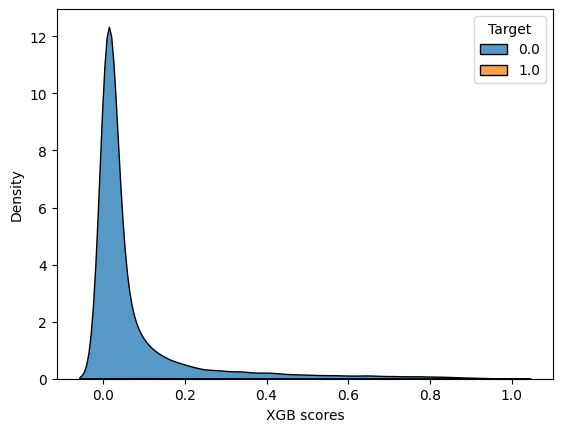

In [25]:
# add normal density gra

sns.kdeplot(data=graph_df, x="XGB scores", hue="Target", multiple="stack")

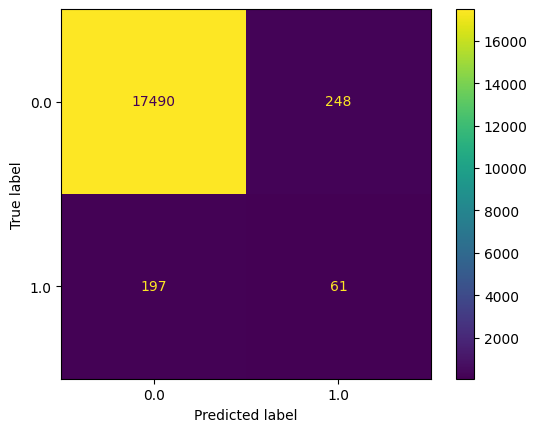

In [31]:
cm = confusion_matrix(y_test, np.where(y_test_xgb_pipe_pred[:, 1]>0.7,1,0), labels=xgb_pipeline.steps[1][1].best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb_pipeline.steps[1][1].best_estimator_.classes_)

disp.plot()